Here, will be replicating a ML research paper and creating a Vision Transformer (ViT) from scratch using PyTorch.

The goal of paper replicating is to replicate the advances in ML papers with code so as to use those techniques for one's own problems.

ML paper replicating involves turning a ML paper comprised of images/diagrams, math and text into usable code.

**ViT paper**: https://arxiv.org/abs/2010.11929

**Replicating the work of others is a fantastic way to practice one's skills.**

Several places to find and read ML research papers and code are:

    arXiv
    AK Twitter
    Papers with Code
    lucidrains' vit-pytorch GitHub repo (inspiration was gathered for this notebook from this repo)

The process for replicating all papers will be slightly different but doing one will give enough momentum to do more.

A **Transformer architecture** is generally considered to be any NN that uses the **attention mechanism** as its primary learning layer.

**The Vision Transformer (ViT) architecture was designed to adapt the original Transformer architecture to vision problems.**

Although ViT has gone through many iterations over the years, the original, **vanilla ViT**, arch. will be replicated here.

### 0. Getting setup

In [1]:
import torch
import torchvision

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
# For visual representations of the models' arch.
from torchinfo import summary

# data_setup to prepare the dataloaders and engine for training as the main backbone for the models
from going_modular import data_setup, engine
# set_seeds() to set random seed values, download_data to download the required datasets and plot_loss_curves
# to inspect the model's training results
from helper_functions import download_data, set_seeds, plot_loss_curves

C:\Users\ritis\Desktop\PyTorch-Learning\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get Data

In [4]:
# Download pizza, steak and sushi images from GitHub soure link to the respective destination
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data\pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup train and test dirs for DataLoaders creation
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Creating Datasets and DataLoaders

First ViT reference: In table 3, the training resolution is 224 and batch size is 4096.

#### 2.1 Prepare transforms for images

In [6]:
# Creating transform to prepare the images to be fed into ViT

# Image size from table 3 of ViT paper
IMG_SIZE = 224

# transform pipeline creation manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
print(f"Created transform is: {manual_transforms}")

Created transform is: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


#### 2.2 Turn images into DataLoader's

In [7]:
# pin_memory = True parameter in the create_dataloaders() function to speed up computation. But not necessarily benefittng.

BATCH_SIZE = 32 # lower than the ViT paper but it is because of starting small; also, 4096 is too big of a value for a single GPU.

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir,
                                                                               transform=manual_transforms, batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x17d0da5cf90>,
 ['pizza', 'steak', 'sushi'])

#### 2.3 Visualize a single image

In [8]:
# Checking out some images after loading the data completely.

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from that batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

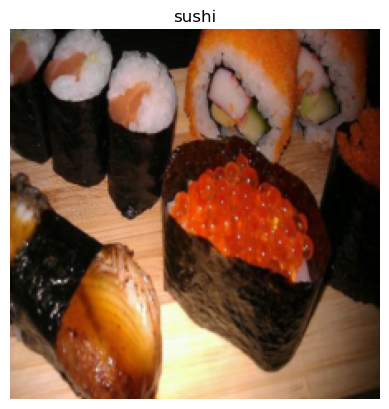

In [9]:
# Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # Channels last to suit matplotlib
plt.title(class_names[label])
plt.axis(False);

### 3. Replicating the ViT paper: an overview

#### 3.1 Inputs and outputs, layers and blocks

    ViT is a DL NN architecture.
    NN arch. is generally comprised of layers.
    A collection of layers is often referred to as a **block**.
    And, stacking many blocks together gives the whole architecture.

This implies that a block also takes an input performing a series of functions on it and gives an output.

For better understanding, break down. Start with inputs and outputs of single layer and work up to the inputs and outputs of the ewhole model.

#### 3.2 Getting specific: What's ViT made of ?

Main three resources will be looked at fot thr arch. design are:

    1. **Figure 1** - Complete arch of ViT in a graphical overview sense.
    2. **Four equations in section 3.1 of paper** - Give a bit more of mathematical grounding to the overview in Figure 1.
    3. **Table 1** - Shows the various hyperparamter settings for different ViT model variants.
    
However, the smallest version, ViT-Base will be focused in here.

##### 3.2.1 Exploring Figure 1

![Figure 1 from ViT paper](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png)

Goal is to replicate each of the inputs, outputs, layers and blocks using PyTorch code.

Several stages comprising the ViT architecture are:

    1. Patch + Position Embedding (inputs) - Turns the i/p img into a seq of image patches and adds a position number for the order in which patches come.
    
    2. Linear projection of flattened patches (Embedded patches) - Image patches get turned into an embedding (Img gets turned into patches and then projected to an embedding). The benefit of embedding is that it is a learnable representation (vector form) of the img that can improve with training.
    
    3. Norm - Short for Layer Normalization/LayerNorm (technique used for regularizing a NN i.e., reduce overfitting). torch.nn.LayerNorm()
    
    4. Multi-Head Attention - A Multi-Headed Self-Attention layer or MSA for short. torch.nn.MultiheadAttention()
    
    5. MLP (Multilayer perceptron) - MLP often refers to any collection of feedforward layers. In ViT paper, it is referred to as MLP block and it contains 2 nn.Linear() layers with a nn.GELU() non-linearity activation b/w them and a nn.Dropout() layer after each.
    
    6. Transformer Encoder - It is a collection of the layers listed above. 2 skip connections inside the Transformer encoder ("+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of each other.
    
    7. MLP Head - The output layer of the architecture. Converts learned features of an input to a class output. This can also be called the Classifier head since working with image classification. Its structure is similar to MLP block.

##### 3.2.2 Exploring the Four Equations

![Four Equations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

These four equations represent the math behind the four major parts of ViT arch.

![Connection between Figure 1 and equations from section 3.1](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png)

Following the coloured lines and  arrows will reveal the main concepts of the ViT architecture.

![title](C:\Users\ritis\Desktop\PyTorch-Learning\ViT_screenshot.png)

##### 3.2.3 Equation 1 overview

This equation deals with the class token, patch embedding and position embedding (**E** is for embedding) of the input image.

##### 3.2.4 Equation 2 overview

This equation says that for every layer from 1 to L, there is a MSA layer wrapping a LayerNorm layer (LN).  
The addition at the end is of the input to the output of that block forming a **skip/residual connection**.   
This layer as a whole is called **MSA block**.

##### 3.2.5 Equation 3 overview

This equation says that for every layer from 1 to L, there is also an MLP layer wrapping a LayerNorm (LN) layer.  
The addition at the end is showing the presence of a skip/residual connection.   
This layer as a whole is called **MLP block**.

##### 3.2.6 Equation 4 overview

This equation says that for the last layer L, the output y is the 0 index token of z wrapped in a LayerNorm (LN) layer.

##### 3.2.7 Exploring Table 1

Hyperparameters setting for different variants of ViT.

Break dowm of the table hyperparameters is:

    Layers - No. of transformer Encoder blocks present (each containing an MSA and an MLP block) ?
    
    Hidden size, D - Embedding dimension throughout the architecture; it is the size of the vector the image gets turned into when it gets patched and embedded. Larger embeddings, more computation. However, generally, larger embedding dimension, more information can be captured, better results.
    
    MLP size - No. of hidden units in the MLP layers ?
    
    Heads - No. of heads in MSA layers ?
    
    Params - Total params of the model ? Generally, more params, better performance at cost of computation.

#### 3.3 Author's workflow for replicating papers **(Useful)**

### 4. Equation 1: Split data into patches and creating class, position and patch embedding

Lets start with the **patch embeddings**.

It means to turn the input images in a sequence of patches and then embedding those patches.

The term **learnable** in learnable representations is important because this means the numerical representation of input img (that the model sees) can be improved over time.

Breaking down the opening paragraph of section 3.1 of ViT paper as follows:

D - size of the patch embeddings. Diff values for D for various ViT models is in Table 1. Basically, D is the embedding size.  
Image starts as 2D with size (H * W * C); (H, W) is the resolution of the og img and C is the number of channels.  
Image gets converted to a sequence of flattened 2D patches with size (N * (P^2 . C)); (P, P) is the resolution of each image patch (**patch size**) and N = HW/P^2 is the resulting number of patches serving as i/p seq length for the Transformer.  
![Mapping patch and position embedding portion of ViT arch from Figure 1 to Equation 1](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-annotated.png)

#### 4.1 Calculate patch embedding input and output shapes by hand

Lets manually check all these shape values by creating variables to mimic each of these terms above.

In [10]:
# Example values creation
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P; because used by the best performing version of ViT-Base

# Calculate N i.e., number of patches
number_of_patches = int((height * width) / patch_size**2)
print(f"N with H={height}, W={width} and P={patch_size} is {number_of_patches}")

N with H=224, W=224 and P=16 is 196


Now, replicate the input and output shapes of the patch embedding layer.
    
    2D (H, W, C) -> (N, (P^2, C))

In [11]:
# Input shape (single image size); Img starts as this 2D size
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (og img): {embedding_layer_input_shape}")
print(f"Output shape (flatened patched og 2D image seq): {embedding_layer_output_shape}")

Input shape (og img): (224, 224, 3)
Output shape (flatened patched og 2D image seq): (196, 768)


#### 4.2 Turning a single image into patches

Now, the ideal input and output shapes for the patch embedding layer are known.

Before creating the patch embedding layer as per the piece by piece replication of the overall arch with focus on i/ps and o/ps of individual layers, first visualize the turning of a single image into patches.

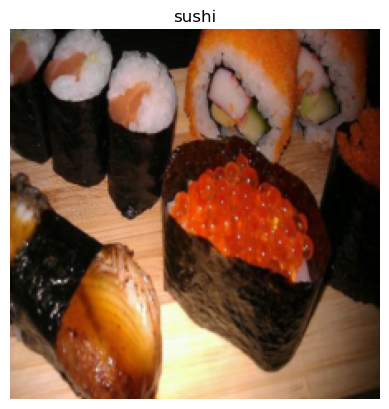

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # Channels last for matplotlib
plt.title(class_names[label])
plt.axis(False);

**How about starting by just visualizing the top row of patched pixels ?**

This can be done by indexing on the different image dimensions.

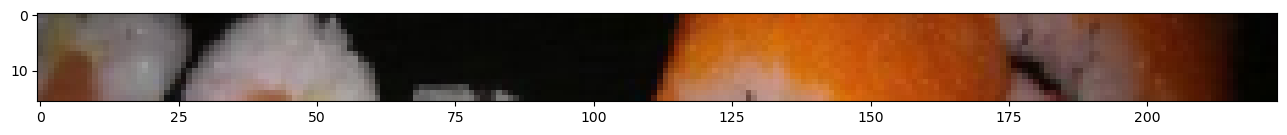

In [13]:
# Image shape change for compatibility with matpotlib
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

This is the top row. Need to turn it into patches. Done by iterating over the number of patches that would be in a row.

Number of patches per row: 14.0 with patch size being (16, 16) pixels.



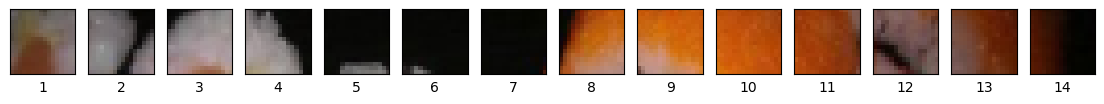

In [14]:
# Hyperparams setup and img_size & patch_size should be compatible (divisible)
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size%patch_size == 0, "Image and patch size are incompatible. Should be divisible."
print(f"Number of patches per row: {num_patches} with patch size being {patch_size, patch_size} pixels.\n")

# Create a series of subplots for number of patches in a row
fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, figsize=(num_patches, num_patches), sharex = True, sharey = True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    # print(f"{patch}")
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

**How about doing it for the whole image ?**

Iterate through the indices for height and width both and plot each patch as a subplot.

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: (16, 16) pixels


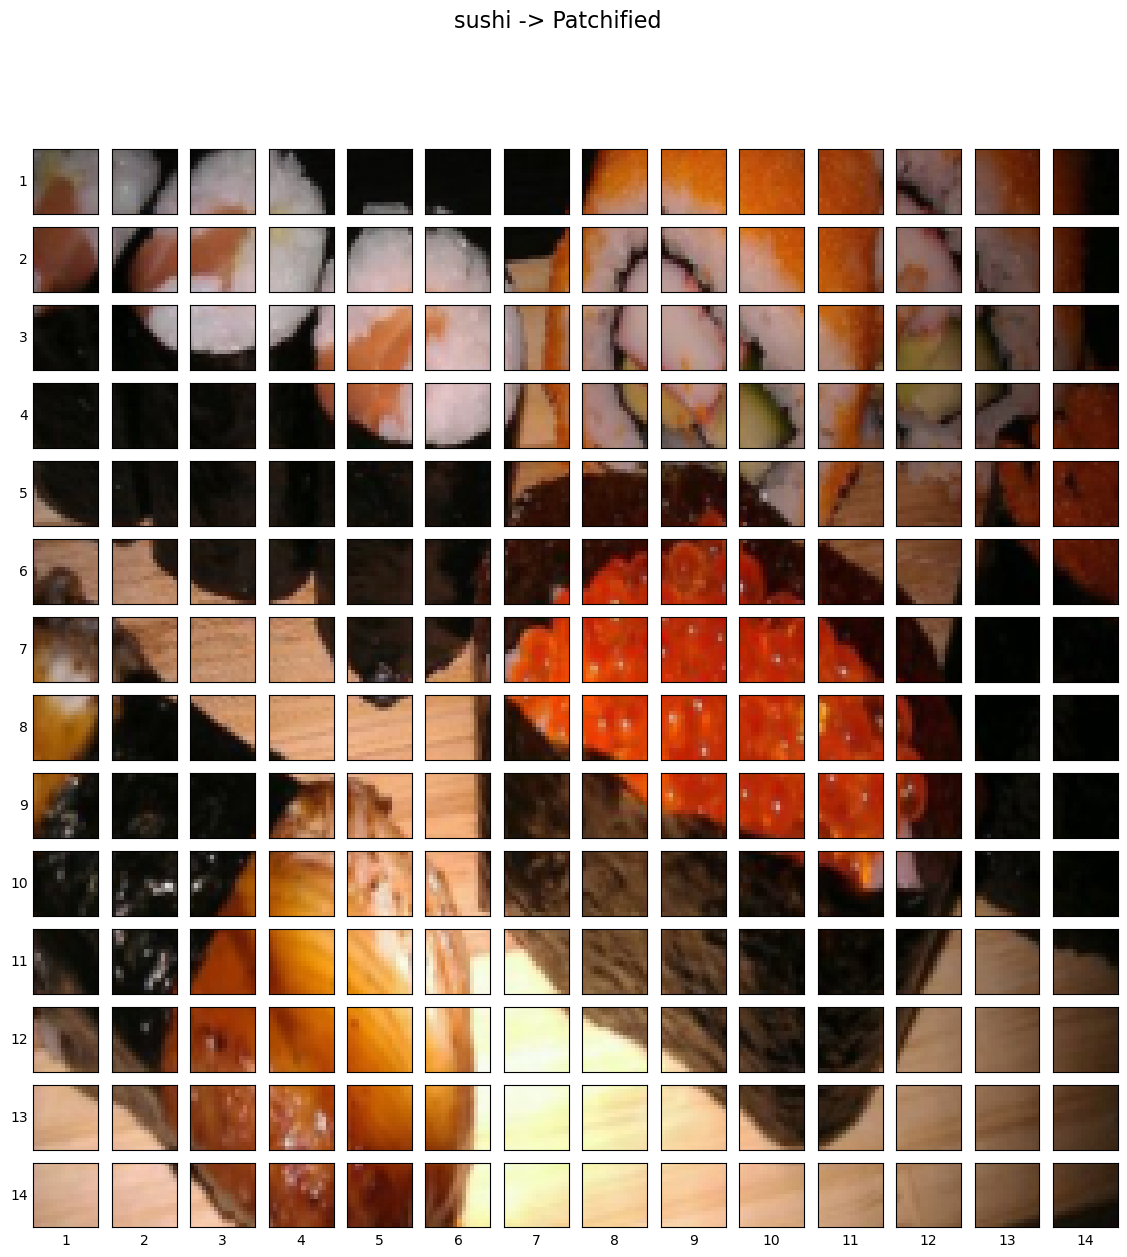

In [15]:
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size, patch_size} pixels")

# Create a series of plots for rows and cols of the whole image
fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size, figsize=(num_patches, num_patches),
                       sharex = True, sharey = True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # Plot each of the image patch from the permuted image which is compatible with matplotlib
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

        # Setup label information, remove ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
        rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Setup a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 16)
plt.show()

**Now, how to turn each of these patches into an embedding and convert them into a sequence ?**

#### 4.3 Creating image patches with torch.nn.Conv2d()

Moving towards replicating the patch embedding layers with PyTorch.

This alternative of CNN is given the name **Hybrid Architecture** in the ViT paper.

The **feature map** being referred to in the **Hybrid architecture** are the weights/activations produced by a **convolutional layer** passing over a given image.

![Patching using CNN in action](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif)

*By setting the kernel_size and stride parameters of a torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.*

Remembering the ideal input and output shapes for the patch embedding layer, they can be recreated with:

    torch.nn.Conv2D() - For turning the image into patches of CNN feature maps.
    torch.nn.Flatten() - For flattening the spatial dimensions of the feature map.

In [16]:
# Starting with torch.nn.Conv2d() layer

from torch import nn

# Set the patch size
patch_size = 16

# Create the Conv2d layer with hyperparams from the ViT paper
conv2d = nn.Conv2d(in_channels=3, out_channels=768, # Hidden size D (embedding dimension) from Table 1 for learnable rep to be fed into the Transformer Encoder.
                  kernel_size=patch_size, stride=patch_size, padding=0)

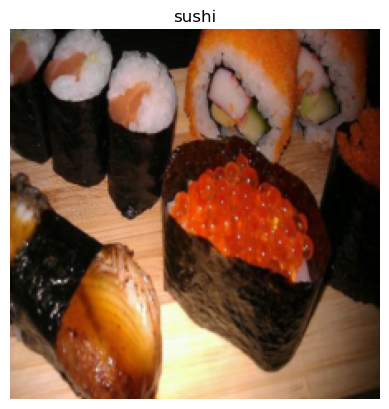

In [17]:
# Passing through a single image and view it
plt.imshow(image.permute(1, 2, 0)) # Channels last for matplotlib compatibility
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # Needed an extra dimension for the batch_size arg being 1 since CNNs expect input as [batch_size, H, W, C]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


The image has now been turned into a series of 768 feature/activation maps by the conv2d layer.  
[batch_size, embedding_dim, feature_map_height, feature_map_width]

Following are the randomly chosen convolutional feature maps; indices: [696, 711, 404, 491, 597]


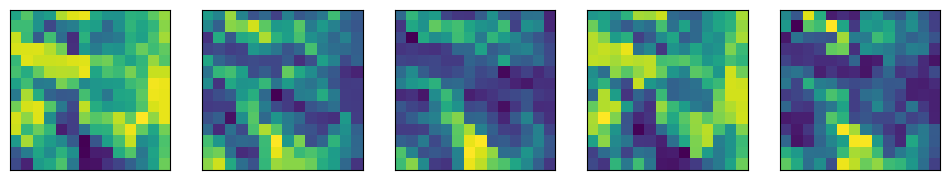

In [19]:
# Visualizing 5 random feature maps produced by conv2d layer
import random
random_indices = random.sample(range(0, 768), k=5) # pick randomly any 5 b/w 0 and the embedding size
print(f"Following are the randomly chosen convolutional feature maps; indices: {random_indices}")

# Plot creation
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot the random image convolutional feature maps
for i, idx in enumerate(random_indices):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

All these feature maps kind of represent the original image. The important thing to note is that these features may change over time as NN learns. Therefore, these feature maps can be considered a **learnable embedding** of the image.

In [20]:
# Check out a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1416, -0.3012, -0.3762, -0.4089, -0.0412, -0.0775, -0.0452,
           -0.2488, -0.4191, -0.2894, -0.2195, -0.1384, -0.2252, -0.0770],
          [-0.2158, -0.2014, -0.5046, -0.3502, -0.4320, -0.3894, -0.5281,
           -0.3860, -0.3614, -0.4474, -0.2873, -0.2451, -0.1863, -0.0791],
          [-0.0601,  0.0070, -0.0376, -0.1785, -0.3115, -0.5019, -0.4818,
           -0.4497, -0.3608, -0.1720, -0.3350, -0.1912, -0.1611, -0.0853],
          [-0.0454, -0.0547, -0.0469, -0.1869, -0.1422, -0.3423, -0.3535,
           -0.4005, -0.1648, -0.2475, -0.1657, -0.1618, -0.0967, -0.1391],
          [-0.3245, -0.0690, -0.0993, -0.0771, -0.0615, -0.0438, -0.0610,
           -0.0643, -0.2022, -0.1469, -0.2755, -0.1950, -0.1893, -0.1809],
          [-0.1033, -0.3426, -0.2927, -0.1780, -0.0924, -0.1724, -0.1350,
           -0.2729, -0.2928, -0.2252, -0.0994, -0.1219, -0.1015, -0.0408],
          [-0.3961, -0.2108, -0.4328, -0.2569, -0.2282, -0.4088, -0.3327,
           -0.3902, -0.3104, -0.

The requires_grad attribute being True means PyTorch is tracking gradients of this feature map and thus, will be updated by gradient descent during training. So, learnable embeddings.

#### 4.4 Flattening the patch embedding with torch.nn.Flatten()

The image has been turned into patch embeddings but are still in 2D format.

**How to get them into desired output shape of patch embedding layer of ViT architecture i.e., 1D sequence of flattened 2D patches, (196, 768) ?** (number_of_patches, embedding_dimension)

In [21]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape}") # [batch, embedding_dim, feature_map_height, feature_map_width]

Current tensor shape: torch.Size([1, 768, 14, 14])


So, the (P^2 . C) part of the desired output shape i.e., the embedding dimension has been got but still need the number of patches.

Hence, only need to flatten the spatial dimensions of the feature map (not the whole tensor) as per the special case of 1x1 spacial size of the patch in the ViT paper and projecting to the Transformer dimension.

In [22]:
# Create flatten layer to only flatten the spatial dims of the feature map using start_dim and end_dim params
flatten = nn.Flatten(start_dim = 2, # flatten feature_map_height (dim 2)
                     end_dim = 3) # flatten feature_map_width (dim 3)

Putting all these together gives:

Og img shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


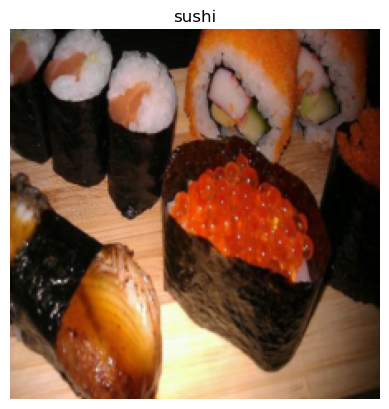

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"Og img shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dim
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Very close to the desired output (**flattened 2D patches**) shape of (196, 768). Currently, (1, 768, 196).

In [24]:
# Getting flattened image patch embeddings (flattened 2D patches) in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2.C, N] -> [batch_size, N, P^2.C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


**Thus, now have matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.**

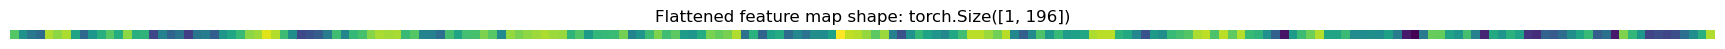

In [25]:
# Visualizing the flattened fature maps

# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot that flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

**This is the output of the patching embedding layer and the input to the rest of the ViT arch.**

In [26]:
# See the flattened feature map as a tensor form
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.1416, -0.3012, -0.3762, -0.4089, -0.0412, -0.0775, -0.0452, -0.2488,
          -0.4191, -0.2894, -0.2195, -0.1384, -0.2252, -0.0770, -0.2158, -0.2014,
          -0.5046, -0.3502, -0.4320, -0.3894, -0.5281, -0.3860, -0.3614, -0.4474,
          -0.2873, -0.2451, -0.1863, -0.0791, -0.0601,  0.0070, -0.0376, -0.1785,
          -0.3115, -0.5019, -0.4818, -0.4497, -0.3608, -0.1720, -0.3350, -0.1912,
          -0.1611, -0.0853, -0.0454, -0.0547, -0.0469, -0.1869, -0.1422, -0.3423,
          -0.3535, -0.4005, -0.1648, -0.2475, -0.1657, -0.1618, -0.0967, -0.1391,
          -0.3245, -0.0690, -0.0993, -0.0771, -0.0615, -0.0438, -0.0610, -0.0643,
          -0.2022, -0.1469, -0.2755, -0.1950, -0.1893, -0.1809, -0.1033, -0.3426,
          -0.2927, -0.1780, -0.0924, -0.1724, -0.1350, -0.2729, -0.2928, -0.2252,
          -0.0994, -0.1219, -0.1015, -0.0408, -0.3961, -0.2108, -0.4328, -0.2569,
          -0.2282, -0.4088, -0.3327, -0.3902, -0.3104, -0.3178, -0.2572,  0.0423,
          -0.025

**Consequently, turned a single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattened Patches" as in Figure 1 of ViT paper).**

#### 4.5 Turning the ViT patch embedding layer into a PyTorch module

A single PyTorch layer for putting everything used to create patch embeddings. 

Specifically, following steps to the PyTorch layer:

    1. Create class PatchEmbedding subclassing nn.Module (so can be used as a PyTorch layer)
    2. Initialize class with params in_channels=3, patch_size=16 (ViT-Base) and embedding_dim=768 (D for ViT-Base from table 1)
    3. Create layer to turn an image into patches using nn.Conv2d() (as in 4.3)
    4. Create layer to flatten the patch feature maps into a single dimesion (as in 4.4)
    5. Define a forward() method to take i/p and pass it through the layers created in 3 and 4
    6. Ensure the output shape reflects the required o/p shape of ViT arch i.e., (N, (P^2 . C)).

In [27]:
# Step 1
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels, patch_size: self-explainatory
        embedding_dim: Size of embedding to turn image into. Defaults to 768 (of ViT-Base).
    """
    # Step 2
    def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
        super().__init__()

        # Step 3
        self.patcher = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)

        # Step 4
        self.flatten = nn.Flatten(start_dim=2, end_dim=3) # Only flatten the feature map dims into a single vector

    # Step 5
    def forward(self, x):
        # Create assertion to check the inputs being of correct shape
        image_resolution = x.shape[-1]
        assert image_resolution%patch_size == 0, f"I/p img size must be divisible by patch_size: img_size - {image_resolution}, patch_size - {patch_size}"

        # Perfrom the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # Step 6 - Check with the output shape order being right
        return x_flattened.permute(0, 2, 1) # From (1, 768, 196) to (1, 196, 768)

**PatchEmbedding layer created!**

In [28]:
# Trying the PatchEmbedding layer on a singlee image

set_seeds()

# Instance creation of the PatchEmbedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Pass a single image through the instance
print(f"Input img shape: {image.unsqueeze(0).shape}")
patch_embedding_image = patchify(image.unsqueeze(0)) # Added extra batch dim
print(f"Output patch embedding shape: {patch_embedding_image.shape}")

Input img shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


![Patch Embedding part of figure 1 and equation 1](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-replicating-the-patch-embedding-layer.png)

In [29]:
# Get summaries for different random input sizes

# Ramdom input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # Incompatible with patch size of 16

# Get summary
summary(PatchEmbedding(), input_size=random_input_image_error, col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20, row_settings=["var_names"])

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

#### 4.6 Creating the class token embedding

![Work on class token embedding i.e., x_class from Equation 1](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-class-token.png)

In the second paragraph of section 3.1 of the ViT paper.

In [30]:
# View the patch embedding and its shape (or the sequence of embedded patches)
print(patch_embedding_image)
print(patch_embedding_image.shape)

tensor([[[-0.5157,  0.1088, -0.0180,  ...,  0.2911, -0.1949,  0.1232],
         [-0.5390, -0.0958, -0.1439,  ...,  0.3672, -0.0375,  0.4160],
         [-0.7717,  0.2118, -0.1510,  ...,  0.4542, -0.1311,  0.2440],
         ...,
         [-0.5113,  0.0629, -0.1033,  ...,  0.3362, -0.2636,  0.2215],
         [-0.3096,  0.0207, -0.0529,  ...,  0.2143, -0.1936,  0.1870],
         [-0.1685,  0.0036, -0.0339,  ...,  0.0401, -0.0885,  0.1015]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])


Now, to do the prepend thing, need to create a learnable embedding in the shape of embedding_dim D shape and then add it to the number_of_patches N dimension.

**Creating a learnable embedding for the class token as follows:**

In [31]:
# Get the batch size and embedding dimension
batch_size = patch_embedding_image.shape[0]
embedding_dimension = patch_embedding_image.shape[-1]

# Create class token embedding as a learnable parameter that shares the same size as the embedding dim (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True) # ensure the embedding is learnable

# Show the first 10 exs of class_token
print(class_token[:, :, :10])

# The number_of_tokens dim of class_token is 1 since only want to prepend one class token value to start of patch embed. seq.
print(f"{class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension


Although the learnable class embedding is created using torch.ones() for demonstration purposes here, in reality, it is created using torch.randn() since MLMis all about randomness.

In [32]:
# Prepending the class token embedding to the sequence of image patches
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedding_image), dim = 1) # Concat on first dim

# Print the sequence with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(patch_embedded_image_with_class_embedding.shape)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5157,  0.1088, -0.0180,  ...,  0.2911, -0.1949,  0.1232],
         [-0.5390, -0.0958, -0.1439,  ...,  0.3672, -0.0375,  0.4160],
         ...,
         [-0.5113,  0.0629, -0.1033,  ...,  0.3362, -0.2636,  0.2215],
         [-0.3096,  0.0207, -0.0529,  ...,  0.2143, -0.1936,  0.1870],
         [-0.1685,  0.0036, -0.0339,  ...,  0.0401, -0.0885,  0.1015]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768])


**Learnable class token embedding prepended.**

![All done for patch embed. + class token embed.](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-prepending-the-learnable-class-token.png)

Note that the learnable class token embedding has one value for each of the embedding dimensions. [1, 768].

#### 4.7 Creating the position embedding

![positional embeddings from fig and eqn](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-the-position-embeddings.png)

The positional information can be important when considering what's in an image (without positional info and a flattened seq could be seen as having no order and thus, no patch relates to any other patch).

In [33]:
# View the seq of patch embed.s with the prepended class embed.s
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5157,  0.1088, -0.0180,  ...,  0.2911, -0.1949,  0.1232],
          [-0.5390, -0.0958, -0.1439,  ...,  0.3672, -0.0375,  0.4160],
          ...,
          [-0.5113,  0.0629, -0.1033,  ...,  0.3362, -0.2636,  0.2215],
          [-0.3096,  0.0207, -0.0529,  ...,  0.2143, -0.1936,  0.1870],
          [-0.1685,  0.0036, -0.0339,  ...,  0.0401, -0.0885,  0.1015]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Eq. 1 states that the position embeddings (E_pos) should have the shape (N+1) x D. Have already got the N and D values.

**Will be using standard learnable 1D position embeddings.**

In [34]:
# Calculate N
number_of_patches = int ((height * width) / patch_size ** 2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True) # To make it learnable

# Show the first 10 sequences (patches) and 10 position embedding values and check position embedding shape
print(position_embedding[:, :10, :10])
print(position_embedding.shape)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
torch.Size([1, 197, 768])


**Position embeddings created.**

In [35]:
# Adding these positional embeddings to the sequence of patch embeddings with a prepended class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding # Acc to eq 1
print(patch_and_position_embedding)
print(patch_and_position_embedding.shape)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4843, 1.1088, 0.9820,  ..., 1.2911, 0.8051, 1.1232],
         [0.4610, 0.9042, 0.8561,  ..., 1.3672, 0.9625, 1.4160],
         ...,
         [0.4887, 1.0629, 0.8967,  ..., 1.3362, 0.7364, 1.2215],
         [0.6904, 1.0207, 0.9471,  ..., 1.2143, 0.8064, 1.1870],
         [0.8315, 1.0036, 0.9661,  ..., 1.0401, 0.9115, 1.1015]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


![title](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-patch-embeddings-with-learnable-class-token-and-position-embeddings.png)

#### 4.8 Putting it all together: from image to embedding

Completed the replication of equation 1 from section 3.1 of the ViT paper.
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}

Now is the time to put together everything to go from input image, x to output embedding, z_0.

Specifically, following are the steps:

    1. Set the patch size to 16 due to its wide use in the ViT paper.
    2. Get single image, print its shape and store its height and width.
    3. Add a batch dimension to single image to be compatible with PatchEmbedding layer.
    4. Create PatchEmbedding layer (4.5) instance with patch_size=16 and embedding_dim=768 (Table 1).
    5. Pass single image through the instance in 4 to create a sequence of patch embeddings.
    6. Create a class token embedding (4.6).
    7. Prepent the class token embedding to the patch embeddings created in step 5.
    8. Create a position embedding (4.7).
    9. Add the position embedding to class token and patch embedding created in step 7.

Make sure to set the random seeds and print different tensors' shapes along the way.

In [36]:
set_seeds()

# Step 1
patch_size = 16

# Step 2
print(f"Image shape is: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Step 3
x = image.unsqueeze(0)
print(f"Compatible image shape with layers: {x.shape}")

# Step 4
patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Step 5
patch_embeddings_seq = patch_embedding_layer(x)
print(f"Seq of patch embed.s shape: {patch_embeddings_seq.shape}")

# Step 6
batch_size=patch_embeddings_seq.shape[0]
embedding_dimension = patch_embeddings_seq.shape[-1]
class_token_embedding = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True) # learnable
print(f"Class token embedding shape: {class_token_embedding.shape}")

# Step 7
patch_embeddings_seq_class_token = torch.cat((class_token, patch_embeddings_seq), dim = 1)
print(f"Seq of patch embed.s with class token shape: {patch_embeddings_seq_class_token.shape}")

# Step 8
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True) # learnable

# Step 9
patch_and_position_embedding = patch_embeddings_seq_class_token + position_embedding
print(f"Seq of patch embed.s with class token and position embed.s shape: {patch_and_position_embedding.shape}")

Image shape is: torch.Size([3, 224, 224])
Compatible image shape with layers: torch.Size([1, 3, 224, 224])
Seq of patch embed.s shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Seq of patch embed.s with class token shape: torch.Size([1, 197, 768])
Seq of patch embed.s with class token and position embed.s shape: torch.Size([1, 197, 768])


![Mapping eq 1 from ViT paper to PyTorch code](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-1-putting-it-all-together.png)

**So, got a way to encode the images and pass them to the Transformer Encoder in Figure 1 of the ViT paper.**

![Animated Workflow from patch embeddings to transformer encoder to MLP head in ViT](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif)

From code perspective, the embeddings' creation part is the largest of replicating the ViT paper.

**Hence, moving forward to Equation 2 now!**

### 5. Equation 2: Multi-Head Attention (MSA)

Input data patchified and embedded. Next part is the Transformer Encoder of ViT architecture.

This section has been broken down into two parts: Equation 2 and Equation 3.

Equation 2 will be referred to as the **MSA block**.

![Mapping of MSA, LN, and residual connection block from Figure 1 to Equation 2](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-msa-block-mapped-to-equation.png)

To replicate this part of the ViT architecture, already existing layers in PyTorch will be used.

#### 5.1 The LayerNorm (LN) layer

Layer Normalization normalizes an input over the last dimension.

**torch.nn.LayerNorm layer's** main parameter is **normalized_shape** which can be set to be equal to the dimension size liked to normalize over (and in this case, it will be D or 768 for ViT-Base).

Layer Normalization helps improve training time and model generalization.

Think of any kind of Normalization as **"getting data into a similar format" or "getting data samples into a similar distribution"**.

So, Neural Networks can optimize over data samples with similar distributions (similar mean and std. deviations) easily than those with varying distributions.

#### 5.2 The Multi-Head Self Attention (MSA) layer

The premise of the original attention mechanism developed for text inputs remains for images as well.

**This is so because**:

Since the input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

And, the important interesting thing is that the layer does this on its own given the data.

Good learned representations using MSA layers will show the results in model's performance.

![Formal definition of ViT paper MSA implementation in Appendix A](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-appendix-A.png)

The above image highlights the **triple embedding input** to the MSA layer. This is known as **qkv input** which is fundamental to the **self-attention mechanism**.

In case of images input, the triple embedding input will be three versions of the output of the Norm layer, one for qkv.  
Or, three versions of layer-normalized image patch_and_position_embeddings_with_class_token created in 4.8.

The MSA layer can be implemented in PyTorch with **torch.nn.MultiheadAttention(embed_dim: int, num_heads: int, dropout: float, batch_first: bool)**.

#### 5.3 Replicating Equation 2 with PyTorch layers

Putting together everything discussed above about Eq 2 into code. Specifically, the steps are:

    1. Create class MultiheadSelfAttentionBlock inheriting from torch.nn.Module.
    2. Initialize class with hyperparams from Table 1 for ViT-Base model of ViT paper.
    3. Create layer norm (LN) layer with torch.nn.LayerNorm() with normalized_shape param set as the embedding dimension, D.
    4. Create MSA layer with appropriate embed_dim, num_heads, dropout and batch_first params.
    5. Create forward() method for the class passing in the inputs through LN layer and MSA layer.

In [37]:
# Step 1
class MultiheadSelfAttentionBlock(nn.Module):
    # Step 2
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attn_dropout: float = 0): # from Table 1
        super().__init__()
        # Step 3
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # Step 4
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True) # does batch dim come first ?

    # Step 5
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x, # query embed.s
                                             key = x, # key embed.s
                                             value = x, # value embed.s
                                             need_weights = False) # do we need weights or just the layer outputs ?
        return attn_output

**MSA block created!**

In [38]:
# Trying an instance of this class and passing through an input image embedding created in 4.8

# Instance creation of MuMultiheadSelfAttentionBlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

# Passing the image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"MSA block i/p shape: {patch_and_position_embedding.shape}")
print(f"MSA block o/p shape: {patched_image_through_msa_block.shape}")

MSA block i/p shape: torch.Size([1, 197, 768])
MSA block o/p shape: torch.Size([1, 197, 768])


![Replication of Eq 2 without residual connections](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-2-in-code.png)

**Officially replicated Equation 2 in partial.**

### 6. Equation 3: Multilayer Perceptron (MLP)

**Equation 3** is referred to as the **MLP block**.

![title](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-equation-3-annotated.png)

#### 6.1 The MLP layer(s)

Generally, an MLP follows the pattern of: linear layer -> non-linear layer -> linear layer -> non-linear layer and can refer to any combination of multiple layers.  
However, in ViT paper, MLP structure as defined in section 3.1 is that it contains two layers (nn.Linear) with a GELU (Gaussian Error Linear Units; nn.GELU) non-linearity.

**Linear layer is also referred to as dense or feedforward layer.**

Another detail about the MLP block doesn't appear until Training is that Dropout, when used, is applied after every dense layer except for the qkv-projections and directly after adding positional- to patch embeddings.  
This means that every linear layer (or dense) in the MLP block has a dropout layer. Param of dropout layer can be found in Table 3 for ViT-Base model.

Hence, the structure of the MLP block in ViT is:

**layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout**

Hyperparam values for these linear layers are available in Table 1 (MLP size/no. of hidden units and D is output size of the MLP block).

#### 6.2 Replicating Equation 3 with PyTorch layers

Theoretical discussion about Eq 3 above to code.

Specifically, the steps are:

    1. Create class MLPBlock inheriting from torch.nn.Module.
    2. Initialize class with hyperparams from Table 1 and Table 3 of ViT paper for ViT-Base model.
    3. Create LN layer with normalized_shape param set to be the embedding dimension, D.
    4. Create a sequential series of MLP layers using nn.Linear(), nn.Dropout() and nn.GELU() with appropriate hyperparam values from Table 1 and Table 3.
    5. Create a forward() method for the class passing the inputs through the LN layer and MLP layer(s).

In [39]:
# Step 1
class MLPBlock(torch.nn.Module):
    # Step 2
    def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, # From Table 1 for ViT-Base
                 dropout: float = 0.1): # From Table 3
        super().__init__()
        # Step 3
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # Step 4
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    # Step 5
    def forward(self, x):
        x = self.layer_norm(x)
        z = self.mlp(x)
        return x

**MLPBlock class created!**

In [40]:
# Trial of the above MLPBlock class over an MSABlock output

# MLPBlock class instance creation
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)

# Passing MSABlock output through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"MLP block i/p shape: {patched_image_through_msa_block.shape}")
print(f"MLP block o/p shape: {patched_image_through_mlp_block.shape}")

MLP block i/p shape: torch.Size([1, 197, 768])
MLP block o/p shape: torch.Size([1, 197, 768])


Although the in and out shapes remain the same, they do change within the MLP block while going through the Linear layers.

![Figure 1 to code for Eq 3 partially](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-equation-3-mapped-to-code.png)

**Officially replicated the Eq 3 in partial.**

Therefore, got Equations 2 and 3 partially replicated in PyTorch code. Will put them together in the next section 7.1 in completion to create the Transformer Encoder.

### 7. Create the Transformer Encoder

Stack together the **MultiheadSelfAttentionBlock (Eq 2)** and **MLPBlock (Eq 3)** and create the Transformer Encoder of the ViT architecture.

The Transformer Encoder will encode the patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks as per section 3.1 of ViT paper.

In ViT architecture, the residual connection means the input of MSA block is added back to the output of MSA block before it passes to MLP block. The same thing happens with MLP block before it goes onto the next Transformer Encoder block.

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn deeper representations to be learned.

#### 7.1 Creating a Transformer Encoder by combining the custom made layers

The steps to be implemented are as follows:

    1. Create class TransformerEncoderBlock inheriting from torch.nn.Module.
    2. Initialize class with hyperparams from Table 1 and Table 3 of ViT paper for ViT-Base model.
    3. Instantiate MSA block for Eq 2 using MultiheadSelfAttentionBlock from 5.2 with appropriate params.
    4. Instantiate MLP block for Eq 3 using MLPBlock from 6.2 with appropriate params.
    5. Create forward() method for this class.
    6. Create skip connection for MSA block.
    7. Create skip connection for MLP block.

In [41]:
# Step 1
class TransformerEncoderBlock(torch.nn.Module):
    # Step 2
    def __init__(self, embedding_dim: int=768, num_heads: int=12, mlp_size: int=3072, # from Table 1
                 mlp_dropout: float=0.1, attn_dropout: float=0): # from Table 3
        super().__init__()
        # Step 3
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        # Step 4
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    # Step 5
    def forward(self, x):
        # Step 6
        x = self.msa_block(x) + x
        # Step 7
        x = self.mlp_block(x) + x
        
        return x

**Transformer Encoder block created!**

![Transformer Encoder blocks mapped to respective Equations](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-highlighted.png)

![Mapping ViT Transformer Encoder to PyTorch code](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-transformer-encoder-mapped-to-code.png)

In [42]:
# Get a summary of the Transformer Encoder block passing in an input of shape (1, 197, 768)

# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Get the model summary
summary(model = transformer_encoder_block, input_size=(1, 197, 768), col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

Even though the input and output shape of the Transformer Encoder block are the same, it doesn't mean that their values were not manipulated. The whole goal of this block (and its stacking) is to learn a deep representation of the input using the various layers in between.

#### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

PyTorch now has in-built Transformer layers as part of torch.nn.

In [43]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768, # Hidden size D from Table 1
                                                             nhead = 12, # number of heads from Table 1
                                                             dim_feedforward = 3072, # MLP size from Table 1
                                                             dropout = 0.1, # Dropout amt for dense layers from Table 3
                                                             activation = "gelu", # GELU non-linearity
                                                             batch_first = True,
                                                             norm_first = True) # Normalize first or after the MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [44]:
# Get a model summary to inspect it further
summary(model = torch_transformer_encoder_layer, input_size=(1,197,768), col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Since the ViT architecture uses several Transformer layers stacked on top of each for the full architecture, this can be done with **torch.nn.TransformerEncoder(encoder_layer, num_layers)**, where **encoder_layer** is the target Transformer Encoder layer and **num_layers** is the number of Transformer Encoder layers to stack together.

### 8. Putting it all together to create ViT

Time to code all four equations using the chunks created above to create full ViT architecture.

In [45]:
# Step 1: Create ViT class inheriting from torch.nn.Module
class ViT(torch.nn.Module):
    # Step 2: Initialize class with hyperparams from Table 1 and Table 3
    def __init__(self, ing_size:int=224, in_channels:int=3, patch_size:int=16,
                 num_transformer_layers:int=12, embedding_dim:int=768, mlp_size:int=3072, num_heads:int=12,
                 attn_dropout:float=0, mlp_dropout:float=0.1, embedding_dropout:float=0.1, num_classes:int=1000): #Default for ImageNet of 1000 classes
        super().__init__()

        # Step 3: Ensure image size is divisible by patch_size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size: Image size - {img_size} and patch size - {patch_size}"

        # Step 4: Calculate the number of patches
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # Step 5: Create learnable class token embedding (prepended to the sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        # Step 6: Create learnable position embedding vector
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)

        # Step 7: Create embedding dropout layer value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Step 8: Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

        # Step 9: Create Transformer Encoder blocks (Can stack them using nn.Sequential())
        # "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads, mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # Step 10: Create MLP head or classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    # Step 11: Create forward() method
    def forward(self, x):
        # Step 12: Get batch size
        batch_size = x.shape[0]

        # Step 13: Create class token embedding and expand it to match the batch size (Eq 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Step 14: Create patch embedding (Eq 1)
        x = self.patch_embedding(x)

        # Step 15: Concat class and patch embeddings (Eq 1)
        x = torch.cat((class_token, x), dim = 1)

        # Step 16: Add position embedding to patch embedding (Eq 1)
        x = self.position_embedding + x

        # Step 17: Run embedding dropout
        x = self.embedding_dropout(x)

        # Step 18: Pass patch + position + class embedding through transformer encoder layers (Eq 2 and 3)
        x = self.transformer_encoder(x)

        # Step 19: Put 0 index logit through classifier head (Eq 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [46]:
# Trial of the ViT class by passing a random single image tensor through it
set_seeds()

# Random single image shape tensor creation
random_image_tensor = torch.randn(1, 3, 224, 224)

# ViT class instance creation with num_classes attribute value passed
vit = ViT(num_classes=len(class_names))

# Pass the tensor to ViT instance
vit(random_image_tensor)

tensor([[0.1097, 0.9838, 1.5081]], grad_fn=<AddmmBackward0>)

Therefore, the ViT architecture outputted 3 logit values, one for each of the 3 classes for the respective imput image.

#### 8.1 Getting a visual summary of the ViT model

In [47]:
summary(model = vit, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [48]:
vit_1000 = ViT(num_classes=1000)
summary(model = vit_1000, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### 9. Setting up training code for the ViT model

Everything is now good to go for Training except a few things. These are a loss function and an optimizer.

#### 9.1 Creating an optimizer

The authors of the ViT paper chose to use the **Adam Optimizer** with default beta parameter values of 0.9 and 0.999.  
The **weight_decay parameter** is set to 0.1.   
The **learning rate** of the optimizer is set to 0.003 as per Table 3.   
Lower **batch size** will be used than 4096 which is used in ViT paper.

#### 9.2 Creating a loss function

**No mention is there for loss or loss function or criterion in the ViT paper.**  
However, will be using **torch.nn.CrossEntropyLoss()** because working with the problem of multi-class classification, the same for the ViT paper.

#### 9.3 Training the ViT model

In [49]:
# To use the train() function to train the ViT model
from going_modular import engine

# Setup optimizer to optimize ViT model params using hyperparams from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(), lr = 3e-3, # Base lr from Table 3 for all ViT models
                             betas = (0.9, 0.999), # default values but also mentioned in section 4.1 of the ViT paper
                             weight_decay = 0.3) # from section 4.1 and Table 3 for all ViT models of the ViT paper

# Setup loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model for 10 epochs (smaller than ViT paper to ensure everything works) and save the training results to a dictionary
results = engine.train(model=vit, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn,
                       epochs=10, device=device)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


Epoch: 1 | train_loss: 1.5496 | train_acc: 0.3398 | test_loss: 2.0444 | test_acc: 0.2604


 20%|████████████████▍                                                                 | 2/10 [08:51<33:34, 251.77s/it]


Epoch: 2 | train_loss: 1.2131 | train_acc: 0.4297 | test_loss: 1.5623 | test_acc: 0.2604


 30%|████████████████████████▌                                                         | 3/10 [10:10<20:12, 173.23s/it]


Epoch: 3 | train_loss: 1.2694 | train_acc: 0.2930 | test_loss: 1.2021 | test_acc: 0.2604


 40%|████████████████████████████████▊                                                 | 4/10 [10:46<11:53, 118.92s/it]


Epoch: 4 | train_loss: 1.1912 | train_acc: 0.2852 | test_loss: 1.2510 | test_acc: 0.1979


 50%|█████████████████████████████████████████▌                                         | 5/10 [11:33<07:45, 93.04s/it]


Epoch: 5 | train_loss: 1.2238 | train_acc: 0.3008 | test_loss: 1.1820 | test_acc: 0.2604


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [12:09<04:54, 73.68s/it]


Epoch: 6 | train_loss: 1.2554 | train_acc: 0.3047 | test_loss: 1.3342 | test_acc: 0.1979


 70%|██████████████████████████████████████████████████████████                         | 7/10 [12:43<03:01, 60.63s/it]


Epoch: 7 | train_loss: 1.4652 | train_acc: 0.2891 | test_loss: 1.0966 | test_acc: 0.2604


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [13:17<01:44, 52.23s/it]


Epoch: 8 | train_loss: 1.1410 | train_acc: 0.2852 | test_loss: 1.1603 | test_acc: 0.2604


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [13:52<00:46, 46.84s/it]


Epoch: 9 | train_loss: 1.1379 | train_acc: 0.3008 | test_loss: 1.0098 | test_acc: 0.5417


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [14:27<00:00, 86.79s/it]


Epoch: 10 | train_loss: 1.2451 | train_acc: 0.2578 | test_loss: 1.4796 | test_acc: 0.2604


Although the ViT model is working without any errors, the results don't look good.

**Is it because of a few missing things ?**

#### 9.4 What the training setup is missing ?

**The main reason behind poor performance of this ViT model is the scale**.   
The scale in terms of far larger amounts of data and a longer training schedule than the employed ones here.   
Broadly, the original ViT paper has more elaborate training scheme than this leading to performance differences.  

Also, ViT arch.'s size and high number of params (increased learning capabilities) and amount of data it uses (increased learning oppurtunities) allow the use of techniques such as lr warmup, lr decay and gradient clipping in the ViT paper training scheme to prevent overfitting.

However, many pretrained models like these are already available for use.

#### 9.5 Plot the loss curves of the ViT model

One of the best things to visualize for a model is its **loss curves**.

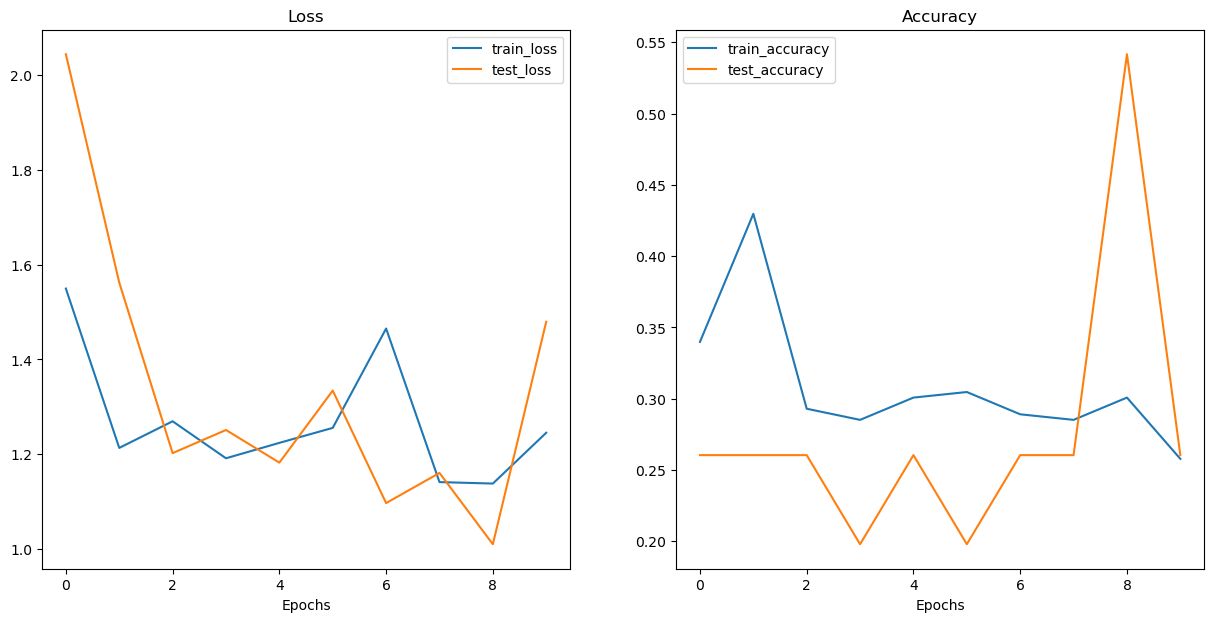

In [50]:
plot_loss_curves(results)

These results are likely because of the difference in data resources and training regime of this ViT model v/s the ViT paper.   
Also, seems the model is **severely underfitting**.

### 10. Using a pretrained ViT from torchvision.models on the same dataset

The ViT model trained from scratch achieved less than optimal results hence, need to take benefits of transfer learning i.e., using a pretrained model which really shine.

#### 10.1 Why use a pretrained model ?

**Because of monetory and time costs.**   
It costs a significant amount of money to train a model on a bunch of GPUs along with a long time to train them.   
Most of the times, this cost is not a viable spend for many people thus, better to use the already available pretrained models at places like torchvision.models, timm library and HuggingFace Hub saving them this cost.

Using a pretrained model will allow to leverage benefits of a specific model architecture rather than creating one's own custom architecture.

#### 10.2 Getting a pretrained ViT model and creating a feature extractor TL model

In [52]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Specifically, the steps to get the pretrained ViT-Base model and preparing it for FoodVision Mini use case will be:

    1. Get pretrained weights for ViT-Base from torchvision.models.ViT_B_16_Weights.DEFAULT. (ImageNET-1K)
    2. Setup a ViT model instance via torchvision.models.bit_b_16, pass it pretrained wts in step 1 and send it to target device.
    3. Freeze all the base model layers of the ViT model in step 2 by setting their requires_grad = False.
    4. Update classifier head of ViT model in step 2 to suit this problem by changing number of out_features to the problem's number of classes.

In [53]:
# Step 1
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT means the best available

# Step 2
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Step 3
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Step 4
set_seeds() # To ensure same initialization with linear head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit # Model Output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\ritis/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|███████████████████████████████████████████████████████████████████████████████| 330M/330M [01:40<00:00, 3.46MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

**Pretrained ViT feature extractor model created!**

In [54]:
# model summary check
summary(model = pretrained_vit, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

This shows that the pretrained model should train a lot faster, and could even use a larger batch size since less param updates are going to be taking up memory.

#### 10.3 Preparing data for the pretrained ViT model

In [55]:
# Download the pizza, steak and sushi images data
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination = "pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [56]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

If using a pretrained model, it is generally important to **ensure the custom data is transformed/formatted in the same way the data the original model was trained on**.

In [57]:
# Get automatic transforms from pretrained ViT weights to transform the images into accepted input tensors
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [60]:
# Setup dataloaders from the transformed images' tensors
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                    test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                    batch_size=32) # Can be increased if have more samples as less trainable params are there because of it being a feature extractor model

#### 10.4 Train feature extractor ViT model

Feature extractor model and dataloaders both are ready.

Use the Adam optimizer with lr of 1e-3 and CrossEntropyLoss() as the loss function.

In [61]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit, train_dataloader=train_dataloader_pretrained, test_dataloader=test_dataloader_pretrained,
                                     optimizer=optimizer, loss_fn=loss_fn, epochs=10, device=device)

 10%|████████▏                                                                         | 1/10 [02:01<18:16, 121.80s/it]


Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665


 20%|████████████████▌                                                                  | 2/10 [02:37<09:27, 70.88s/it]


Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977


 30%|████████████████████████▉                                                          | 3/10 [03:07<06:08, 52.65s/it]


Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081


 40%|█████████████████████████████████▏                                                 | 4/10 [03:39<04:25, 44.31s/it]


Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:12<03:21, 40.34s/it]


Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:43<02:28, 37.04s/it]


Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280


 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:14<01:44, 34.92s/it]


Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [05:44<01:07, 33.60s/it]


Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [06:15<00:32, 32.77s/it]


Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:46<00:00, 40.60s/it]


Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


#### 10.5 Plot feature extractor ViT model loss curves

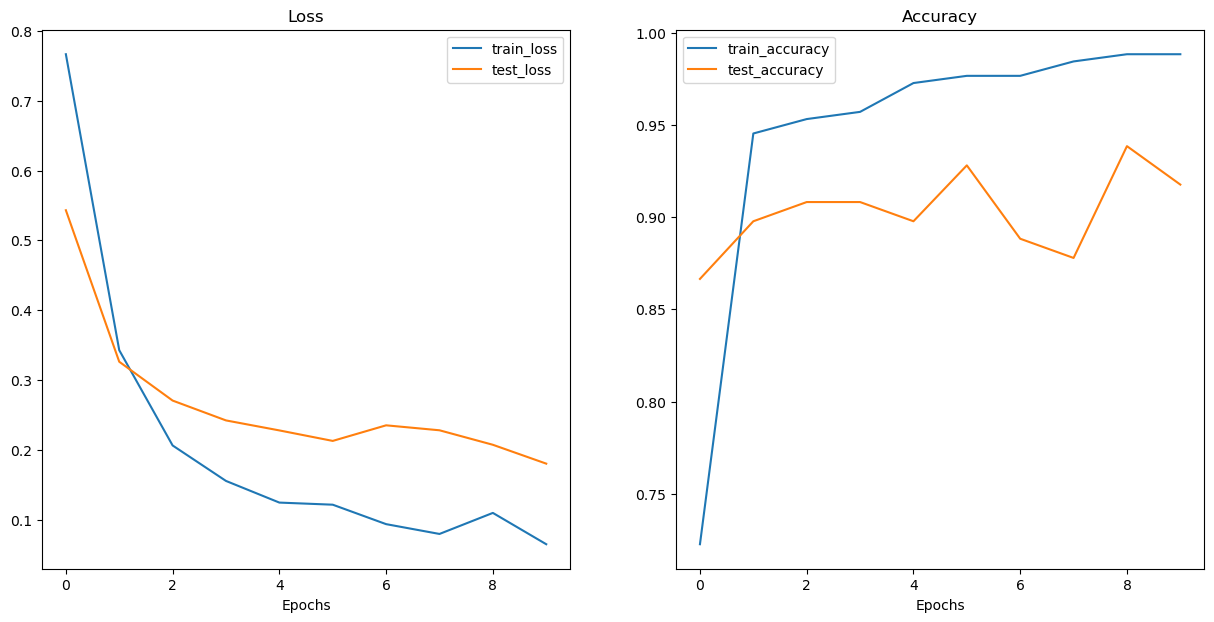

In [62]:
plot_loss_curves(pretrained_vit_results)

These are some really good loss curves. Kind of like an ideal loss cure but not completely. In that direction, however.

No.

#### 10.6 Save feature extractor ViT model and check file size

Now, might want to try deploying the model to see how it goes in production. For that, save it first.

In [63]:
from going_modular import utils

utils.save_model(model=pretrained_vit, target_dir="models", model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

Model is being saved at models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


For deployment of this model, it is good to do model file's size check, in MBs.

For edge devices generally, a smaller model with good performance will be better than a larger model with great performance.

In [65]:
from pathlib import Path

# Get model file size in bytes and then convert into megabytes by division
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


This shows that perhaps such a large model would take longer to load/run and would not provide as good an experience as EffNetB2 which performs similarly but at a much reduced size.

#### 11. Make predictions on a custom image

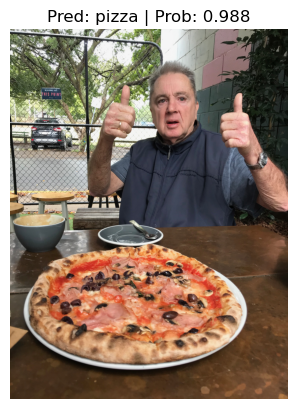

In [66]:
from going_modular.predictions import pred_and_plot_image

pred_and_plot_image(model=pretrained_vit, target_image_path="data/04-pizza-author.jpeg", class_names=class_names)

Therefore, the journey all the way from research paper to usable model code has been concluded.

**The goal of paper replicating is to turn ML research papers (text and math) into usable code.**

Larger models generally perform better but have a larger footprint too (more storage space and longer time to perform inference).

However, big question to ask is:
    **Deployment wise, is the extra performance of a larger model worth it/aligned with the use case ?**